In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/'

SoFi_keys = ['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries', 
             'KBHH2024v12_4factor_profile', 'KBHH2024v12_4factor_timeseries',
             'KBHH2024v15_5factor_profile', 'KBHH2024v15_5factor_timeseries']
Ref_keys = ['002_HOA', '011_HOA', '014_HOA', '003_OOA', '007_LO-OOA', '010_LO-OOA', '005_MO-OOA', '009_MO-OOA', '012_MO-OOA', '030_Birchen', '039_Oak', '041_Pinetree', '042_Poplar']
# 002_HOA is 001_HOA in database

SoFi = read_txt(f'{path}cph central and nørreport measurements/SoFi resultater/', parent_path, SoFi_keys, '\t', None)
for key in [key for key in SoFi_keys if 'timeseries' in key]:
    SoFi[key]['Time'] = pd.to_datetime(SoFi[key]['Time']) + pd.Timedelta(hours = 1)

    SoFi[key]['Date'] = SoFi[key]['Time'].dt.date
    for date in SoFi[key]['Date'].unique():
        mask = SoFi[key]['Date'] == date
        new_df = SoFi[key][mask].reset_index()
        name = key.split('_')[0]
        SoFi[f'{name}_{date}'] = new_df

Ref_MS = read_txt(f'{path}ref ms/txt files/', parent_path, Ref_keys, '\t', None)

ACSM = read_csv(f'{path}cph central and nørreport measurements/Station 1/Timeseries/', parent_path, 't_base', None, 1)
for key in ACSM.keys():
    ACSM[key]['Time'] = ACSM[key]['Time'].round('1s')
ACSM_keys = ['10-12-2024', '11-12-2024', '12-12-2024', '13-12-2024']

MA = read_csv_BC(f'{path}cph central and nørreport measurements/Station 1/MA200/', parent_path, -1)
MA_dict_keys = ['MA200-0369_241210105000', 'MA200-0369_241211095501', 'MA200-0369_241212094705', 'MA200-0369_241213094000']
for key in MA_dict_keys:
    MA[key]['Time'] = MA[key]['Time'].round('60s')

In [6]:
print(SoFi.keys())

dict_keys(['Tinatinv4_2factor_profile', 'Tinatinv4_2factor_timeseries', 'KBHH2024v12_4factor_profile', 'KBHH2024v12_4factor_timeseries', 'KBHH2024v15_5factor_profile', 'KBHH2024v15_5factor_timeseries', 'Tinatinv4_2022-03-08', 'KBHH2024v12_2024-12-10', 'KBHH2024v12_2024-12-11', 'KBHH2024v12_2024-12-12', 'KBHH2024v12_2024-12-13', 'KBHH2024v15_2024-12-10', 'KBHH2024v15_2024-12-11', 'KBHH2024v15_2024-12-12', 'KBHH2024v15_2024-12-13'])


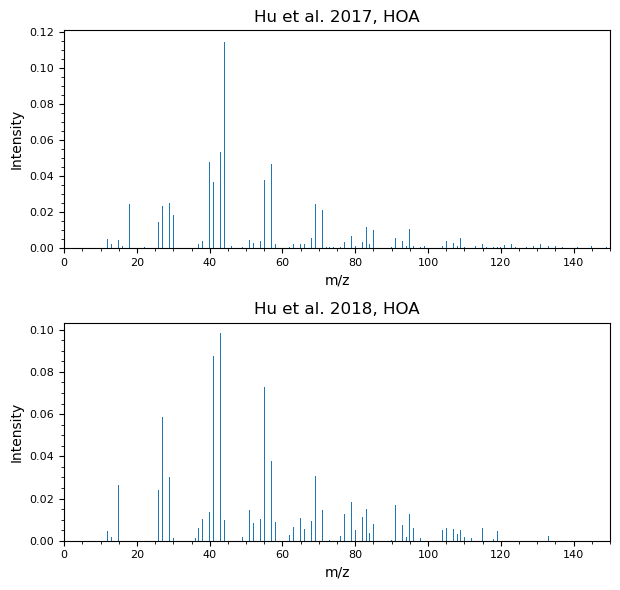

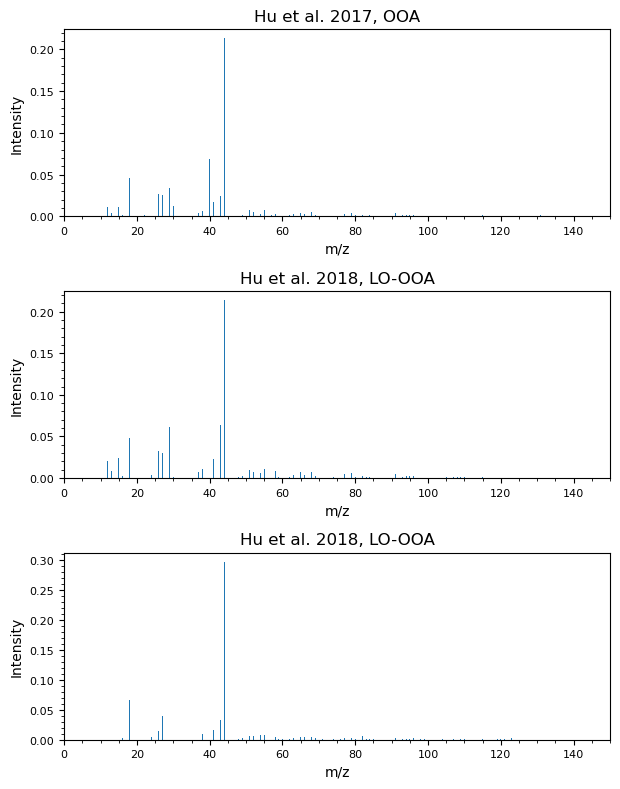

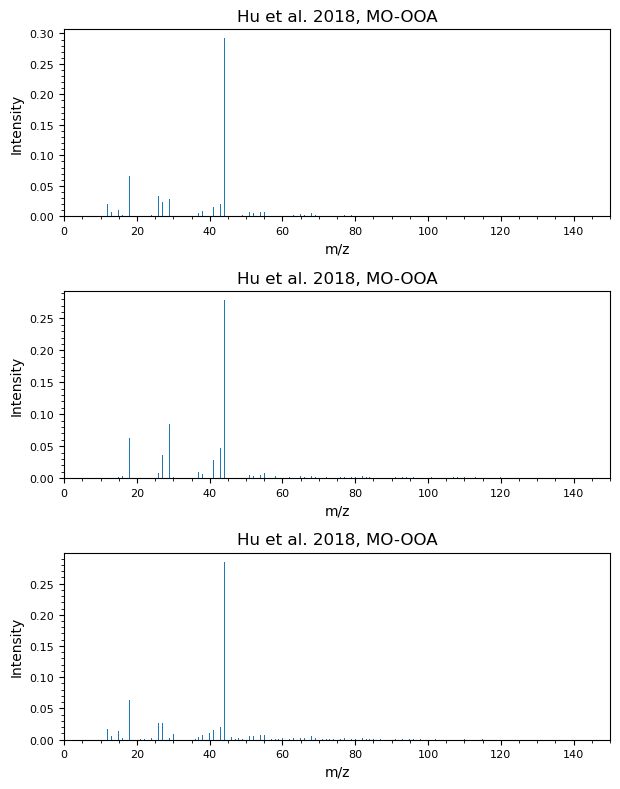

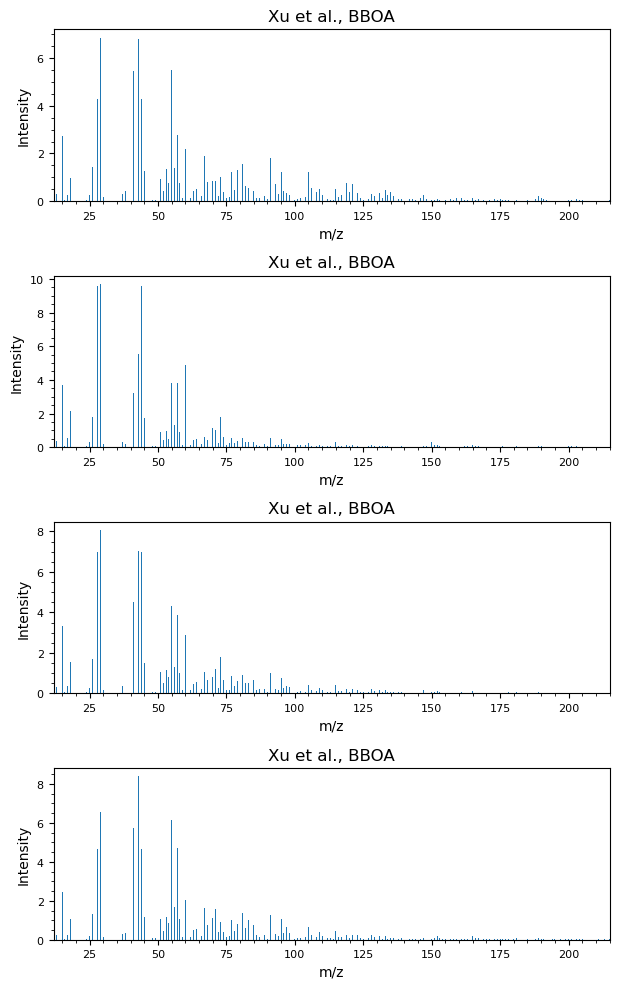

In [7]:
conc_keys = [['HOA_total (002)', 'HOA total (014)'],
             ['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
             ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)'],
             ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)']]
titles = [['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA'],
          ['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA']]
names = ['HOA', 'LO-OOA', 'MO-OOA', 'BBOA']

for i, conc in enumerate(conc_keys):
    if i == 0:
        fig, ax = plt.subplots(2, 1, figsize = (6.3, 6))
        dict_keys = ['002_HOA', '014_HOA']
    if 0 < i < 3:
        fig, ax = plt.subplots(3, 1, figsize = (6.3, 8))
        dict_keys = Ref_keys[i*3:(1+i)*3]
    if 2 < i:
        fig, ax = plt.subplots(4, 1, figsize = (6.3, 10))
        dict_keys = Ref_keys[9:]

    for j, key in enumerate(dict_keys):
        if i < 3:
            plot_MS(ax[j], Ref_MS[key], conc[j], 0.2, titles[i][j], 'tab:blue')
            ax[j].set(xlim = (0, 150))
        else:
            plot_MS(ax[j], Ref_MS[key], conc[j], 0.3, titles[i][j], 'tab:blue')

    fig.tight_layout()
    fig.savefig(f'SoFi/Reference_MS_{names[i]}.pdf', dpi = 600)

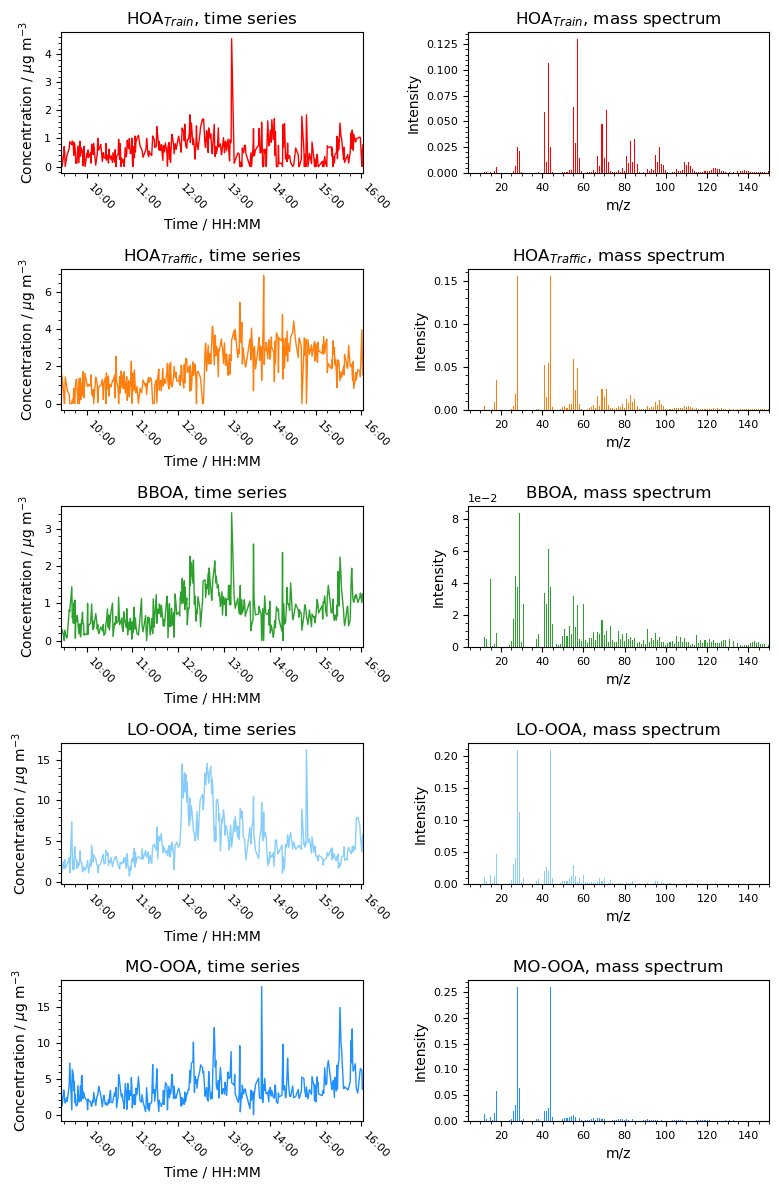

In [8]:
fig, ax = plt. subplots(5, 2, figsize = (8, 12))

colors = ['r', 'tab:orange', 'tab:green', 'lightskyblue', 'dodgerblue'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['HOA$_{Train}$', 'HOA$_{Traffic}$', 'BBOA', 'LO-OOA', 'MO-OOA']

for i in range(5):
    conc = f'Factor{i+1}'

    plot_total(ax[i][0], SoFi['KBHH2024v15_2024-12-11'], conc, colors[i], '-')
    ax[i][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{titles[i]}, time series')
    plot_MS(ax[i][1], SoFi['KBHH2024v15_5factor_profile'], conc, 0.5, f'{titles[i]}, mass spectrum', colors[i])

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v15_5factor_PMF.pdf', dpi = 600)
plt.show()

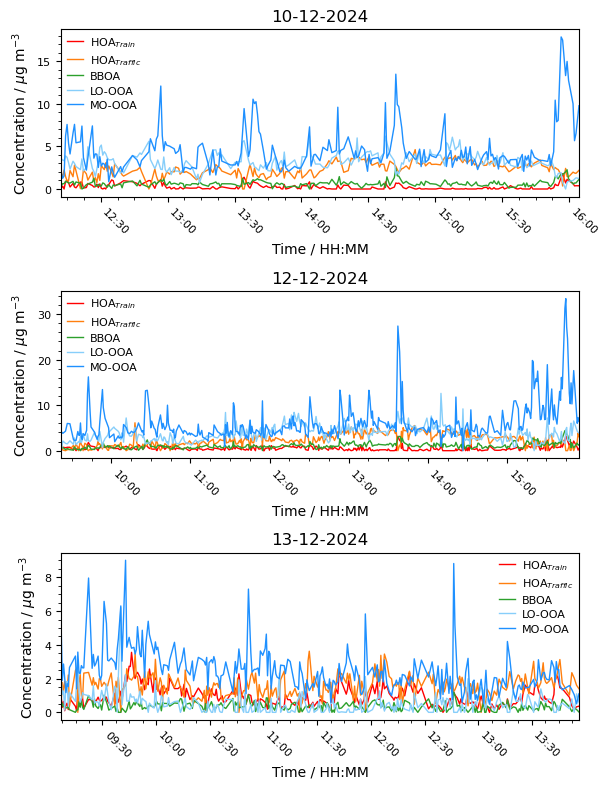

In [9]:
fig, ax = plt. subplots(3, 1, figsize = (6.3, 8))

colors = ['r', 'tab:orange', 'tab:green', 'lightskyblue', 'dodgerblue'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['HOA$_{Train}$', 'HOA$_{Traffic}$', 'BBOA', 'LO-OOA', 'MO-OOA']
dates = ['2024-12-10', '2024-12-12', '2024-12-13']

for i in range(3):
    for j in range(5):
        conc = f'Factor{j+1}'
        ttl = dates[i].split('-')

        plot_total(ax[i], SoFi[f'KBHH2024v15_{dates[i]}'], conc, colors[j], '-')
        ax[i].legend(labels = titles, fontsize = 8)
        ax[i].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{ttl[2]}-{ttl[1]}-{ttl[0]}')

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v15_5factor_PMF_timeseries.pdf', dpi = 600)
plt.show()

eBC vs. HOA: f(x) = 0.118x + 0.122, R2 = 0.1002
eBC vs. BBOA: f(x) = 0.056x + 0.552, R2 = 0.0216
eBC vs. HOA: f(x) = 0.028x + 0.503, R2 = 0.0311
eBC vs. BBOA: f(x) = -0.034x + 0.940, R2 = 0.0394
eBC vs. HOA: f(x) = -0.031x + 0.659, R2 = 0.0093
eBC vs. BBOA: f(x) = 0.037x + 0.995, R2 = 0.0093
eBC vs. HOA: f(x) = 0.027x + 0.652, R2 = 0.0989
eBC vs. BBOA: f(x) = 0.003x + 0.306, R2 = 0.0129


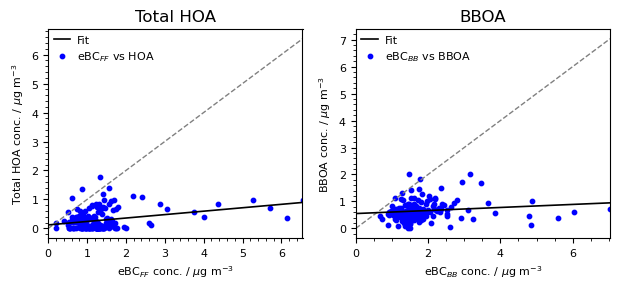

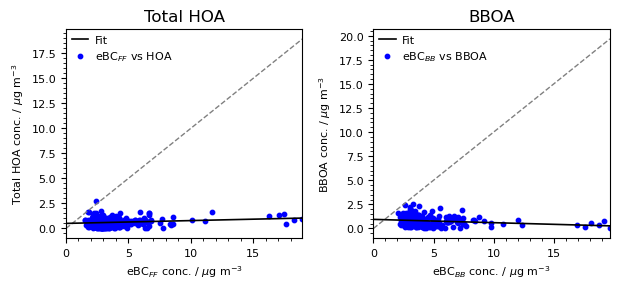

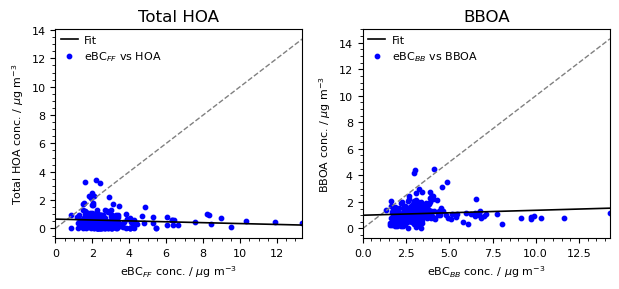

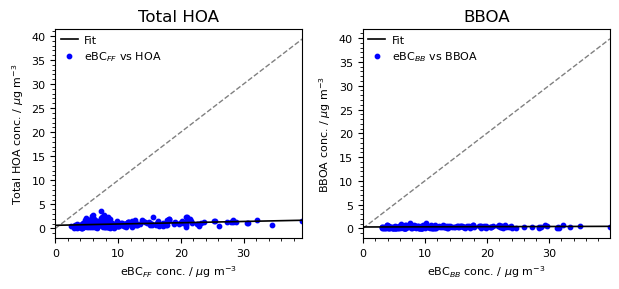

In [10]:
dates = ['2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13']

for i, date in enumerate(dates):
    fig, ax = plt.subplots(1, 2, figsize = (6.3, 3))

    SoFi[f'KBHH2024v15_{date}']['Total HOA'] = SoFi[f'KBHH2024v15_{date}']['Factor1'] + SoFi[f'KBHH2024v15_{date}']['Factor2']

    PMF_HOA = running_mean(SoFi[f'KBHH2024v15_{date}'], 'Total HOA', 'Total HOA', 'Time', '1T', 1, None)
    PMF_HOA = running_mean(SoFi[f'KBHH2024v15_{date}'], 'Factor1', 'Factor1', 'Time', '1T', 1, None)
    PMF_BBOA = running_mean(SoFi[f'KBHH2024v15_{date}'], 'BBOA', 'Factor3', 'Time', '1T', 1, None)
    
    merged = pd.merge(PMF_HOA, MA[MA_dict_keys[i]], on = 'Time')
    merged = pd.merge(PMF_BBOA, merged, on = 'Time')
    merged = merged.dropna()

    x_plot_HOA = np.linspace(0, max(merged['IR BCc']))
    fit_params, fit_errors, squares, ndof, R2 = plot_reference(ax[0], x_plot_HOA, merged, ['IR BCc', 'Factor1'], ['eBC$_{FF}$', 'HOA'], linear, False)
    ax[0].set(xlabel = 'eBC$_{FF}$ conc. / $\mu$g m$^{-3}$', ylabel = 'Total HOA conc. / $\mu$g m$^{-3}$', title = 'Total HOA')
    print(f'eBC vs. HOA: f(x) = {fit_params[0]:.3f}x + {fit_params[1]:.3f}, R2 = {R2:.4f}')

    x_plot_BBOA = np.linspace(0, max(merged['UV BCc']))
    fit_params, fit_errors, squares, ndof, R2 = plot_reference(ax[1], x_plot_BBOA, merged, ['UV BCc', 'BBOA'], ['eBC$_{BB}$', 'BBOA'], linear, False)
    ax[1].set(xlabel = 'eBC$_{BB}$ conc. / $\mu$g m$^{-3}$', ylabel = 'BBOA conc. / $\mu$g m$^{-3}$', title = 'BBOA')
    print(f'eBC vs. BBOA: f(x) = {fit_params[0]:.3f}x + {fit_params[1]:.3f}, R2 = {R2:.4f}')

    fig.tight_layout()
    fig.savefig(f'SoFi/eBCvsProfile_{date}.pdf', dpi = 600)

2024-12-10: f(x) = (0.942+-0.028)x + (0.378+-0.327), R2 = 0.9874
2024-12-11: f(x) = (0.974+-0.021)x + (0.031+-0.203), R2 = 0.9900
2024-12-12: f(x) = (0.973+-0.014)x + (0.289+-0.229), R2 = 0.9928
2024-12-13: f(x) = (0.882+-0.031)x + (0.577+-0.194), R2 = 0.9604


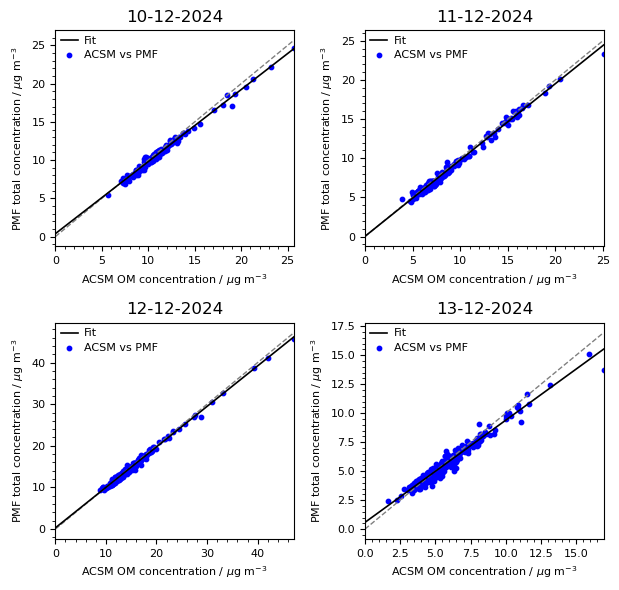

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

dates = ['2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13']
for i, date in enumerate(dates):
    merged = pd.merge(SoFi[f'KBHH2024v15_{date}'], ACSM[ACSM_keys[i]], on = 'Time')
    merged['Total PMF conc'] = merged.iloc[:,2:7].sum(axis = 1)

    ax = axes.flatten()[i]
    x_plot = np.linspace(0, max(merged['Org']))
    fit_params, fit_errors, squares, ndof, R2 = plot_reference(ax, x_plot, merged, ['Org', 'Total PMF conc'], ['ACSM', 'PMF'], linear, False)
    ax.set(xlabel = 'ACSM OM concentration / $\mu$g m$^{-3}$', ylabel = 'PMF total concentration / $\mu$g m$^{-3}$', title = ACSM_keys[i])
    print(f'{date}: f(x) = ({fit_params[0]:.3f}+-{fit_errors[0]:.3f})x + ({fit_params[1]:.3f}+-{fit_errors[1]:.3f}), R2 = {R2:.4f}')

fig.tight_layout()
fig.savefig('SoFi/ACSMvsPMF_orgconc.pdf', dpi = 600)
plt.show()

2024-12-10: f(x) = (0.937+-0.030)x + (0.493+-0.346), R2 = 0.9858
2024-12-11: f(x) = (0.965+-0.020)x + (0.131+-0.203), R2 = 0.9901
2024-12-12: f(x) = (0.948+-0.015)x + (0.645+-0.233), R2 = 0.9925
2024-12-13: f(x) = (0.895+-0.039)x + (0.453+-0.228), R2 = 0.9474


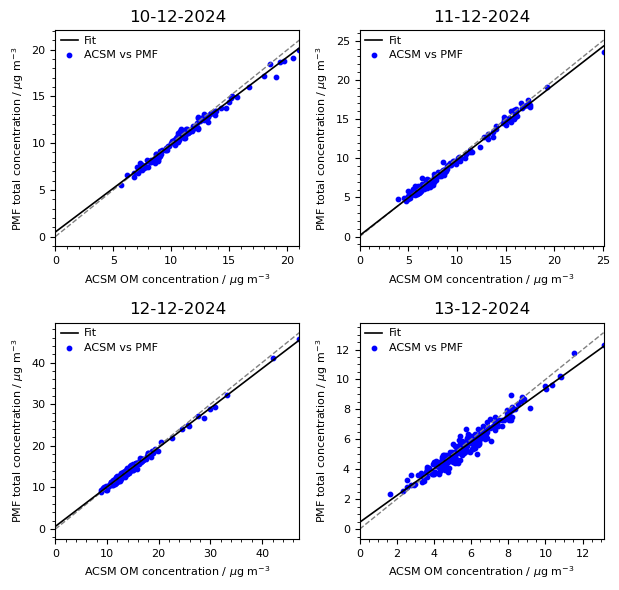

In [14]:
fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

dates = ['2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13']
for i, date in enumerate(dates):
    merged = pd.merge(SoFi[f'KBHH2024v12_{date}'], ACSM[ACSM_keys[i]], on = 'Time')
    merged['Total PMF conc'] = merged.iloc[:,2:6].sum(axis = 1)

    ax = axes.flatten()[i]
    x_plot = np.linspace(0, max(merged['Org']))
    fit_params, fit_errors, squares, ndof, R2 = plot_reference(ax, x_plot, merged, ['Org', 'Total PMF conc'], ['ACSM', 'PMF'], linear, False)
    ax.set(xlabel = 'ACSM OM concentration / $\mu$g m$^{-3}$', ylabel = 'PMF total concentration / $\mu$g m$^{-3}$', title = ACSM_keys[i])
    print(f'{date}: f(x) = ({fit_params[0]:.3f}+-{fit_errors[0]:.3f})x + ({fit_params[1]:.3f}+-{fit_errors[1]:.3f}), R2 = {R2:.4f}')

fig.tight_layout()
fig.savefig('SoFi/ACSMvsPMF_orgconc_run12.pdf', dpi = 600)
plt.show()

2024-12-10: f(x) = (-0.945+-0.185)x + (3.862+-0.139), R2 = 0.0998
2024-12-11: f(x) = (2.842+-0.109)x + (2.378+-0.102), R2 = 0.2188
2024-12-12: f(x) = (0.471+-0.080)x + (3.292+-0.104), R2 = 0.0324
2024-12-13: f(x) = (-0.576+-0.263)x + (0.745+-0.109), R2 = 0.0446


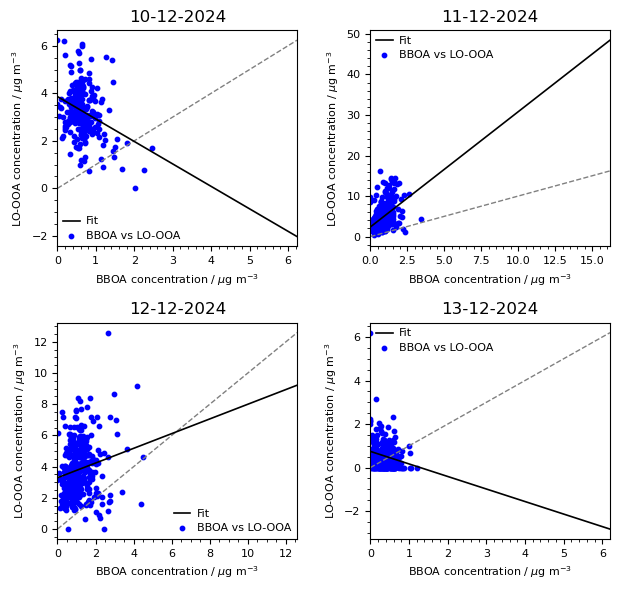

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))

dates = ['2024-12-10', '2024-12-11', '2024-12-12', '2024-12-13']
for i, date in enumerate(dates):
    df = SoFi[f'KBHH2024v15_{date}']

    ax = axes.flatten()[i]
    x_plot = np.linspace(0, max(df['Factor4']))
    fit_params, fit_errors, squares, ndof, R2 = plot_reference(ax, x_plot, df, ['Factor3', 'Factor4'], ['BBOA', 'LO-OOA'], linear, False)
    ax.set(xlabel = 'BBOA concentration / $\mu$g m$^{-3}$', ylabel = 'LO-OOA concentration / $\mu$g m$^{-3}$', title = ACSM_keys[i])
    print(f'{date}: f(x) = ({fit_params[0]:.3f}+-{fit_errors[0]:.3f})x + ({fit_params[1]:.3f}+-{fit_errors[1]:.3f}), R2 = {R2:.4f}')

fig.tight_layout()
fig.savefig('SoFi/BBOAvsLO-OOA.pdf', dpi = 600)
plt.show()

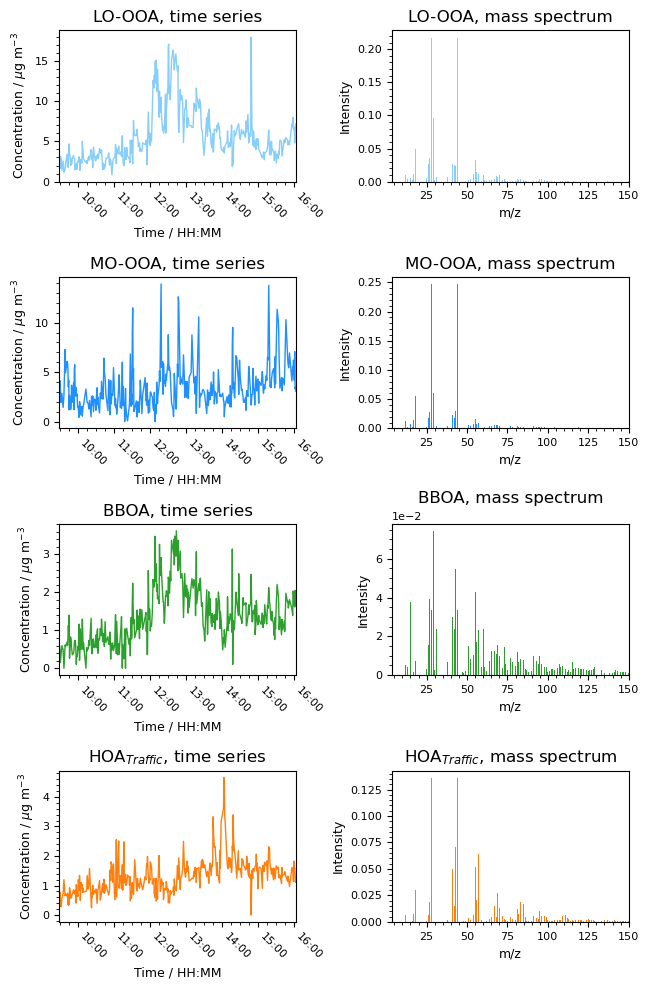

In [ ]:
fig, ax = plt. subplots(4, 2, figsize = (6.7, 10))

colors = ['lightskyblue', 'dodgerblue', 'tab:green', 'tab:orange'] # Train HOA, Traffic HOA, BBOA, LO-OOA, MO-OOA
titles = ['LO-OOA', 'MO-OOA', 'BBOA', 'HOA$_{Traffic}$']

for i in range(4):
    conc = f'Factor{i+1}'

    plot_total(ax[i][0], SoFi['KBHH2024v12_2024-12-11'], conc, colors[i], '-')
    ax[i][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = f'{titles[i]}, time series')
    plot_MS(ax[i][1], SoFi['KBHH2024v12_4factor_profile'], conc, 0.5, f'{titles[i]}, mass spectrum', colors[i])

fig.tight_layout()
fig.savefig('SoFi/KBHH2024v12_4factor_PMF.png', dpi = 600)
plt.show()

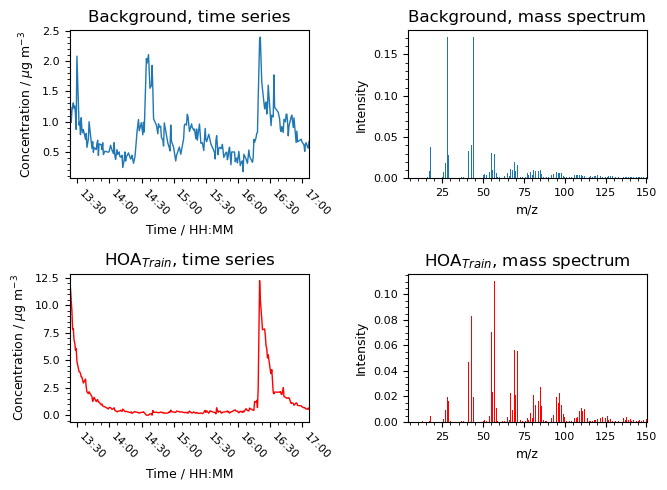

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (6.7, 5))

plot_total(ax[0][0], SoFi['Tinatinv4_2022-03-08'], 'background', 'tab:blue', '-')
ax[0][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'Background, time series')
plot_MS(ax[0][1], SoFi['Tinatinv4_2factor_profile'], 'background', 0.5, 'Background, mass spectrum', 'tab:blue')

plot_total(ax[1][0], SoFi['Tinatinv4_2022-03-08'], 'train HOA', 'r', '-')
ax[1][0].set(xlabel = 'Time / HH:MM', ylabel = 'Concentration / $\mu$g m$^{-3}$', title = 'HOA$_{Train}$, time series')
plot_MS(ax[1][1], SoFi['Tinatinv4_2factor_profile'], 'train HOA', 0.5, 'HOA$_{Train}$, mass spectrum', 'r')

fig.tight_layout()
fig.savefig('SoFi/Tinatin_PMF.png', dpi = 600)
plt.show()

In [ ]:
HOA_markers = [41, 43, 55, 57]
BBOA_markers = [60, 73]
OOA_markers = [28, 29, 44]
marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']

002_HOA: (0.532 +- 5.4088)x + (0.003 +- 0.0903), R2 = 0.2156361972902708
014_HOA: (0.678 +- 5.4088)x + (0.002 +- 0.0903), R2 = 0.4638082096190963


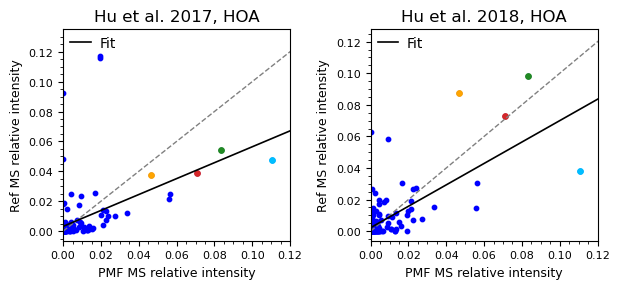

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (6.3, 3))

Ref_df_keys = ['HOA_total (002)', 'HOA total (014)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA']

PMF_MS_validation(axes, SoFi['Tinatinv4_2factor_profile'], 'train HOA', Ref_MS, ['002_HOA', '014_HOA'], Ref_df_keys, HOA_markers, marker_colors)

for ax, ttl in zip(axes, titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, 0.12))

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_trainHOAvsRef.pdf', dpi = 600)
plt.show()

002_HOA: (0.711 +- 4.0250)x + (0.002 +- 0.0869), R2 = 0.6954135811252389
011_HOA: (0.679 +- 3.9562)x + (0.003 +- 0.1069), R2 = 0.28653740500398284
014_HOA: (0.182 +- 4.0250)x + (0.006 +- 0.0869), R2 = 0.06050095706692031
003_OOA: (1.170 +- 4.0250)x + (-0.001 +- 0.0869), R2 = 0.8325132079643123
007_LO-OOA: (1.181 +- 3.9235)x + (-0.002 +- 0.1113), R2 = 0.9262021932043114
010_LO-OOA: (1.610 +- 3.9562)x + (-0.006 +- 0.1069), R2 = 0.9372001195110674


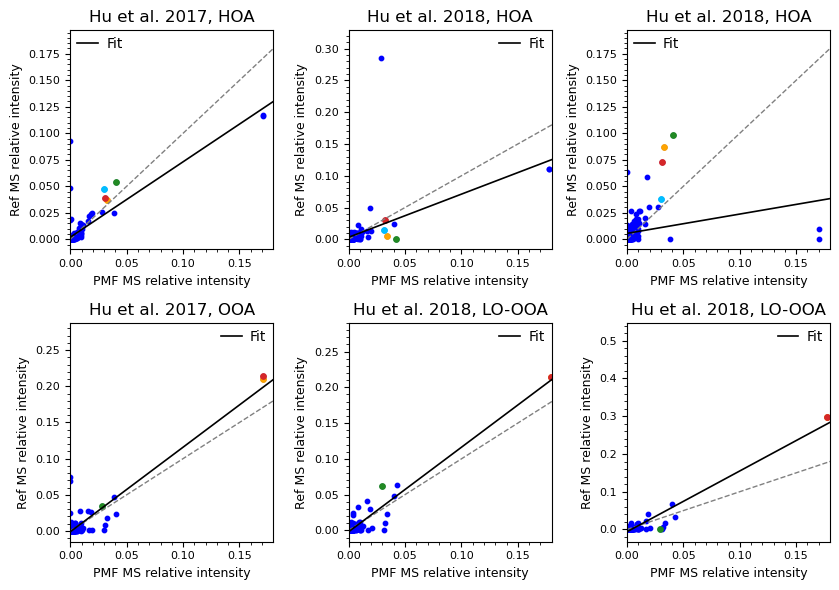

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (8.5, 6))

Ref_df_keys_HOA = ['HOA_total (002)', 'Intensity (011)', 'HOA total (014)']
Ref_df_keys_LOOOA = ['OOA total (003)', 'Intensity (007)', 'Intensity (010)']

titles = ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2018, HOA', 'Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA']

PMF_MS_validation(axes[0], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[:3], Ref_df_keys_HOA, HOA_markers, marker_colors)
PMF_MS_validation(axes[1], SoFi['Tinatinv4_2factor_profile'], 'background', Ref_MS, Ref_keys[3:6], Ref_df_keys_LOOOA, OOA_markers, marker_colors[:3])

for ax, ttl in zip(axes.flatten(), titles):
    ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, 0.18))

fig.tight_layout()
fig.savefig('SoFi/PMF_tinatin_BGvsRef.pdf', dpi = 600)
plt.show()

002_HOA: (0.502 +- 4.8157)x + (0.003 +- 0.0887), R2 = 0.24203946512856586
014_HOA: (0.609 +- 4.8157)x + (0.003 +- 0.0887), R2 = 0.47143601460156226


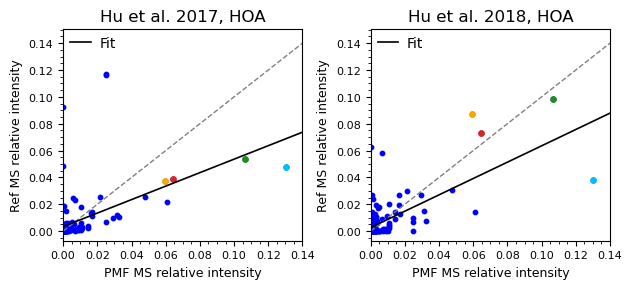

002_HOA: (0.738 +- 4.1193)x + (0.002 +- 0.0871), R2 = 0.7145077478162914
014_HOA: (0.282 +- 4.1193)x + (0.005 +- 0.0871), R2 = 0.13826602260527057


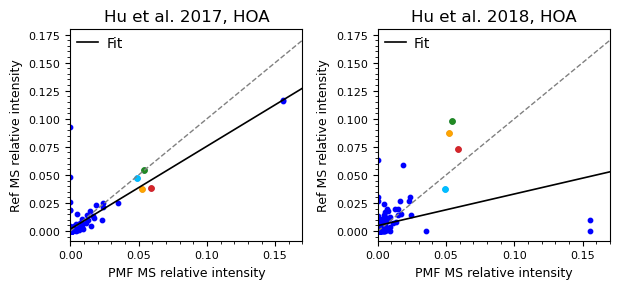

030_Birchen: (1.012 +- 7.3713)x + (0.000 +- 0.1071), R2 = 0.8899718726608129
039_Oak: (1.306 +- 7.3713)x + (-0.002 +- 0.1071), R2 = 0.8086543975233051
041_Pinetree: (1.184 +- 7.3713)x + (-0.001 +- 0.1071), R2 = 0.9052911287420952
042_Poplar: (1.065 +- 7.3713)x + (0.000 +- 0.1071), R2 = 0.8443816342894814


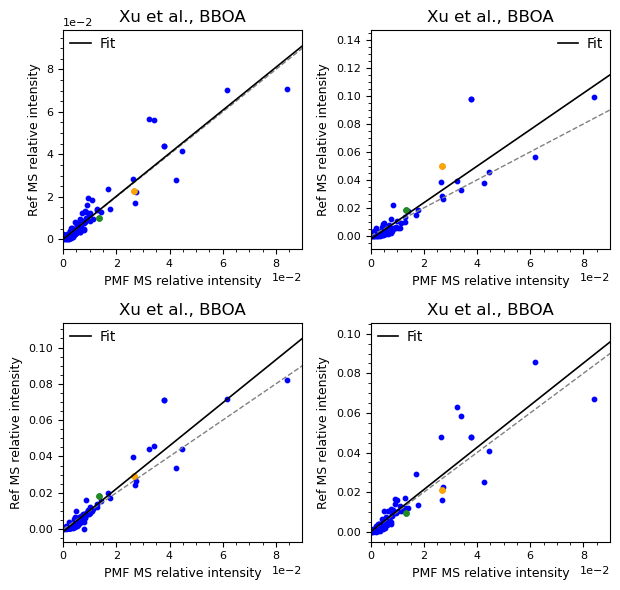

003_OOA: (0.913 +- 3.1325)x + (0.000 +- 0.0852), R2 = 0.8265609018864053
007_LO-OOA: (0.967 +- 3.1799)x + (0.000 +- 0.1085), R2 = 0.9377354145135779
010_LO-OOA: (1.236 +- 3.1733)x + (-0.002 +- 0.1043), R2 = 0.8583295132804674


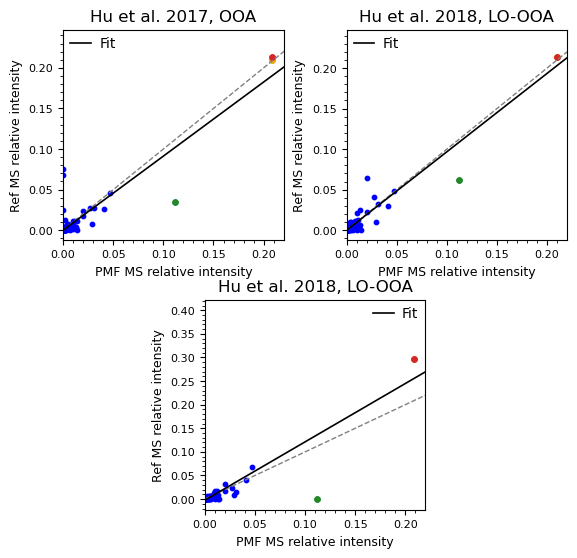

005_MO-OOA: (1.085 +- 2.6649)x + (-0.000 +- 0.1070), R2 = 0.9849819058254855
009_MO-OOA: (1.067 +- 2.6666)x + (-0.000 +- 0.1029), R2 = 0.9909400352467485
012_MO-OOA: (1.053 +- 2.6719)x + (-0.000 +- 0.0845), R2 = 0.9665957448479348


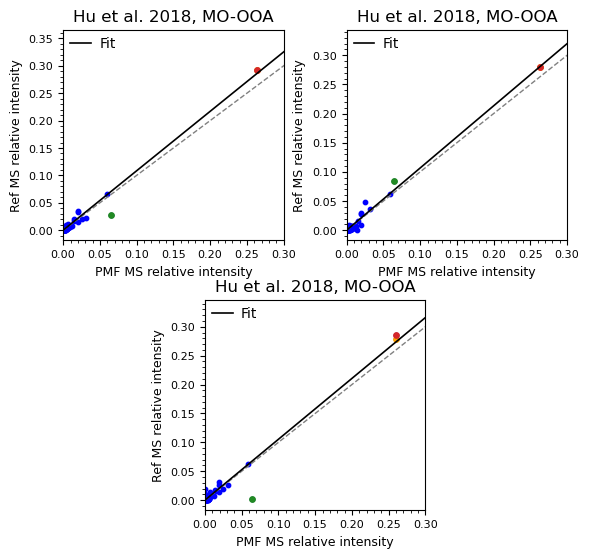

In [ ]:
Ref_keys_5factor = [['002_HOA', '014_HOA'], ['002_HOA', '014_HOA'], Ref_keys[9:], Ref_keys[3:6], Ref_keys[6:9]]
Factors = ['Train HOA', 'Traffic HOA', 'BBOA', 'LO-OOA', 'MO-OOA']
titles = [['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA'],
          ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA'],
          ['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA']]
Ref_df_keys = [['HOA_total (002)', 'HOA total (014)'],
               ['HOA_total (002)', 'HOA total (014)'],
               ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)'],
               ['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
               ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)']]
markers = [HOA_markers, HOA_markers, BBOA_markers, OOA_markers, OOA_markers]

x_max = [0.14, 0.17, 0.09, 0.22, 0.3]

for i in range(5):
    if len(Ref_df_keys[i]) == 3:
        fig = plt.figure(figsize=(6.3, 6))
        # Top-left subplot
        ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
        # Top-right subplot
        ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
        # Bottom-center subplot (same size as above, centered)
        ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
        axes = np.array([ax1, ax2, ax3])
    if len(Ref_df_keys[i]) == 4:
        fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))
    if len(Ref_df_keys[i]) == 2:
        fig, axes= plt.subplots(1, 2, figsize = (6.3, 3))

    factor = f'Factor{i+1}'

    PMF_MS_validation(axes.flatten(), SoFi['KBHH2024v15_5factor_profile'], factor, Ref_MS, Ref_keys_5factor[i], Ref_df_keys[i], markers[i], marker_colors[:len(markers[i])])

    for ax, ttl in zip(axes.flatten(), titles[i]):
        ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, x_max[i]))

    fig.tight_layout()
    fig.savefig(f'SoFi/PMF_KBHH2024v15_{Factors[i]}vsRef.pdf', dpi = 600)
    plt.show()

In [ ]:
PMF_5factor_scaled = SoFi['KBHH2024v15_5factor_profile']
for i in range(5):
    factor = f'Factor{i+1}'

Train_HOA = []
Traffic_HOA = []
BBOA = []
LO_OOA = []
MO_OOA = []
for idx, row in PMF_5factor_scaled.iterrows():
    for marker in [29, 30, 31, 41, 43, 44, 55, 57, 60, 73]:
        if marker == row['m/z']:
            Train_HOA.append(row['Factor1'])
            Traffic_HOA.append(row['Factor2'])
            BBOA.append(row['Factor3'])
            LO_OOA.append(row['Factor4'])
            MO_OOA.append(row['Factor5'])

# HOA
train_4143, traffic_4143 = Train_HOA[3]/Train_HOA[4], Traffic_HOA[3]/Traffic_HOA[4]
train_5557, traffic_5557 = Train_HOA[6]/Train_HOA[7], Traffic_HOA[6]/Traffic_HOA[7]
print(f'Train HOA: f41/f43 = {train_4143:.3f}, f55/f57 = {train_5557:.3f}')
print(f'Traffic HOA: f41/f43 = {traffic_4143:.3f}, f55/f57 = {traffic_5557:.3f}')
# BBOA
bboa_4460, bboa_6073 = BBOA[5]/BBOA[8], BBOA[8]/BBOA[9]
print(f'BBOA: f44/f60 = {bboa_4460:.3f}, f60/f73 = {bboa_6073:.3f}')
# OOA
LO_4443, MO_4443 = LO_OOA[5]/LO_OOA[4], MO_OOA[5]/MO_OOA[4]
print(f'f44/f43: LO-OOA = {LO_4443:.3f}, MO-OOA = {MO_4443:.3f}')
# LO-OOA vs. MO-OOA
LO_MO = np.array(LO_OOA[:6])/np.array(MO_OOA[:6])
print(f'LO-OOA vs. MO-OOA: f29 = {LO_MO[0]:.3f}, f30 = {LO_MO[1]:.3f}, f31 = {LO_MO[2]:.3f}, f43 = {LO_MO[4]:.3f}, f44 = {LO_MO[5]:.3f}')
# BBOA vs. other factors
BBOA_Train = np.array(BBOA[8:])/np.array(Train_HOA[8:])
BBOA_Traffic = np.array(BBOA[8:])/np.array(Traffic_HOA[8:])
BBOA_LO = np.array(BBOA[8:])/np.array(LO_OOA[8:])
BBOA_MO = np.array(BBOA[8:])/np.array(MO_OOA[8:])
print(f'BBOA vs Train HOA: f60 = {BBOA_Train[0]:.3f}, f73 = {BBOA_Train[1]:.3f}')
print(f'BBOA vs Traffic HOA: f60 = {BBOA_Traffic[0]:.3f}, f73 = {BBOA_Traffic[1]:.3f}')
print(f'BBOA vs LO-OOA: f60 = {BBOA_LO[0]:.3f}, f73 = {BBOA_LO[1]:.3f}')
print(f'BBOA vs MO-OOA: f60 = {BBOA_MO[0]:.3f}, f73 = {BBOA_MO[1]:.3f}')

Train HOA: f41/f43 = 0.559, f55/f57 = 0.494
Traffic HOA: f41/f43 = 0.969, f55/f57 = 1.205
BBOA: f44/f60 = 1.412, f60/f73 = 2.010
f44/f43: LO-OOA = 10.322, MO-OOA = 10.380
LO-OOA vs. MO-OOA: f29 = 1.764, f30 = 1.878, f31 = 2.514, f43 = 0.806, f44 = 0.802
BBOA vs Train HOA: f60 = 127.419, f73 = 8.799
BBOA vs Traffic HOA: f60 = inf, f73 = 4.815
BBOA vs LO-OOA: f60 = 1.913, f73 = 2.067
BBOA vs MO-OOA: f60 = inf, f73 = 19.573


003_OOA: (0.906 +- 3.0694)x + (0.000 +- 0.0851), R2 = 0.8484259677877216
007_LO-OOA: (0.954 +- 3.1094)x + (-0.000 +- 0.1083), R2 = 0.9516400740327725
010_LO-OOA: (1.235 +- 3.1045)x + (-0.002 +- 0.1041), R2 = 0.8960554102621795


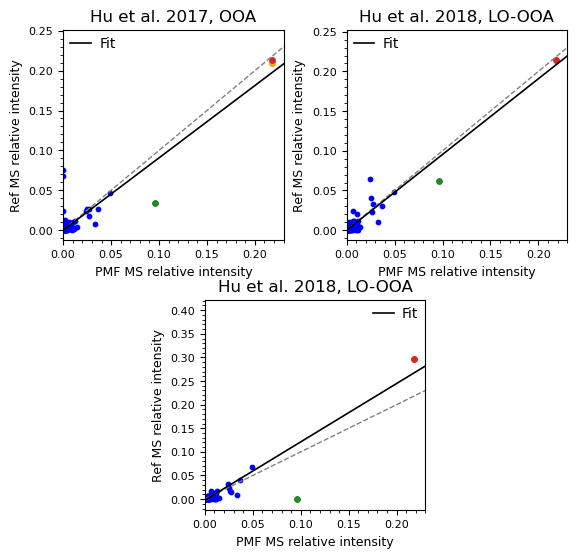

005_MO-OOA: (1.145 +- 2.8011)x + (-0.002 +- 0.1074), R2 = 0.9825300851480013
009_MO-OOA: (1.127 +- 2.8057)x + (-0.001 +- 0.1033), R2 = 0.9914977619276082
012_MO-OOA: (1.106 +- 2.8162)x + (-0.000 +- 0.0847), R2 = 0.9642498273643562


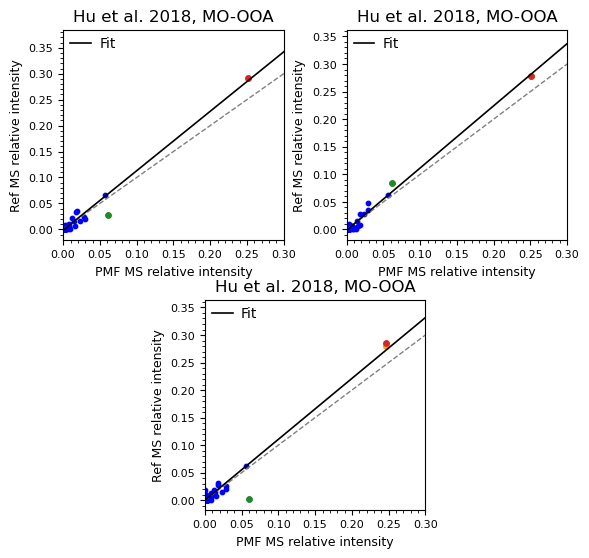

030_Birchen: (1.086 +- 8.1023)x + (0.000 +- 0.1105), R2 = 0.9096954447439718
039_Oak: (1.407 +- 8.1023)x + (-0.003 +- 0.1105), R2 = 0.7774629792097513
041_Pinetree: (1.291 +- 8.1023)x + (-0.002 +- 0.1105), R2 = 0.8911248779658839
042_Poplar: (1.219 +- 8.1023)x + (-0.002 +- 0.1105), R2 = 0.8698623446424018


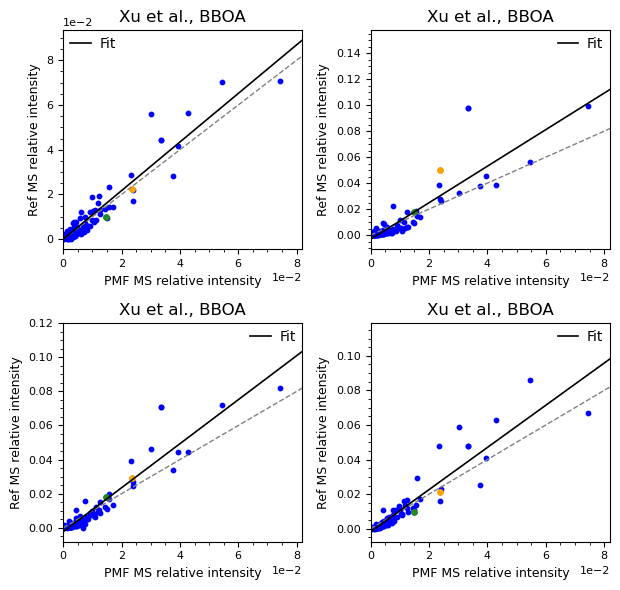

002_HOA: (0.796 +- 4.4374)x + (0.001 +- 0.0878), R2 = 0.7170432893508512
014_HOA: (0.357 +- 4.4374)x + (0.004 +- 0.0878), R2 = 0.19126196382450542


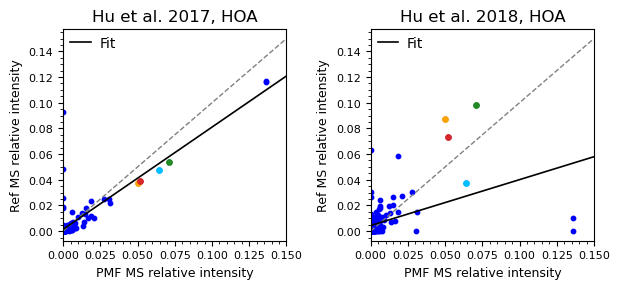

In [ ]:
Ref_keys_4factor = [Ref_keys[3:6], Ref_keys[6:9], Ref_keys[9:], ['002_HOA', '014_HOA']]
Factors = ['LO-OOA', 'MO-OOA', 'BBOA', 'Traffic HOA']
titles = [['Hu et al. 2017, OOA', 'Hu et al. 2018, LO-OOA', 'Hu et al. 2018, LO-OOA'],
          ['Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA', 'Hu et al. 2018, MO-OOA'],
          ['Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA', 'Xu et al., BBOA'],
          ['Hu et al. 2017, HOA', 'Hu et al. 2018, HOA']]
Ref_df_keys = [['OOA total (003)', 'Intensity (007)', 'Intensity (010)'],
               ['Intensity (005)', 'Intensity (009)', 'MO-OOA total (012)'],
               ['Intensity (030)', 'Intensity (039)', 'Intensity (041)', 'Intensity (042)'],
               ['HOA_total (002)', 'HOA total (014)']]
markers = [OOA_markers, OOA_markers, BBOA_markers, HOA_markers]
           

marker_colors = ['orange', 'forestgreen', 'tab:red', 'deepskyblue']
x_max = [0.23, 0.3, 0.082, 0.15]

for i in range(4):
    if len(Ref_df_keys[i]) == 3:
        fig = plt.figure(figsize=(6.3, 6))
        # Top-left subplot
        ax1 = fig.add_axes([0.1, 0.55, 0.35, 0.35])  # [left, bottom, width, height]
        # Top-right subplot
        ax2 = fig.add_axes([0.55, 0.55, 0.35, 0.35])
        # Bottom-center subplot (same size as above, centered)
        ax3 = fig.add_axes([0.325, 0.1, 0.35, 0.35])
        axes = np.array([ax1, ax2, ax3])
    if len(Ref_df_keys[i]) == 4:
        fig, axes = plt.subplots(2, 2, figsize = (6.3, 6))
    if len(Ref_df_keys[i]) == 2:
        fig, axes = plt.subplots(1, 2, figsize = (6.3, 3))

    factor = f'Factor{i+1}'

    PMF_MS_validation(axes.flatten(), SoFi['KBHH2024v12_4factor_profile'], factor, Ref_MS, Ref_keys_4factor[i], Ref_df_keys[i], markers[i], marker_colors[:len(markers[i])])

    for ax, ttl in zip(axes.flatten(), titles[i]):
        ax.set(title = ttl, xlabel = 'PMF MS relative intensity', ylabel = 'Ref MS relative intensity', xlim = (0, x_max[i]))

    fig.tight_layout()
    fig.savefig(f'SoFi/PMF_KBHH2024v12_{Factors[i]}vsRef.pdf', dpi = 600)
    plt.show()